# MATH3349 / 4349 Special Topics: Computational Optimal Transport

## Optimal Transport with the Entropic Regularisation!

$\DeclareMathOperator{\KL}{KL}
\newcommand{\KLdiv}[2]{\KL\pa{#1 \,\vert\, #2}}
\newcommand{\KLproj}{\text{Proj}^{\tiny\KL}}
\renewcommand{\epsilon}{\varepsilon}
\def\ones{\mathbb{I}} $
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This project we solve the discrete optimal transport problem 
problem with the entropic regularisation and Sinkhorn's method for finding the coupling in an iterative manner.

In [1]:
import numpy as np
import scipy.optimize
import scipy.sparse
import matplotlib.pyplot as plt

Consider two dicrete distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^2$.

First we set the number of points $(n,m)$ in the two clouds

In [2]:
n = 20
m = 16

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$. We go back to normally distributed point locations, but now we will have uniform distribution (this will make the visualisation of the coupling a little cleaner)

In [3]:
np.random.seed(2) # We set the random seed to get the same results each time we run this

X = np.vstack((np.random.normal(loc=[-1.0, 2], scale=0.4, size=(n//2,2)), np.random.normal(loc=[-1.0, -2], scale=1.0, size=(n//2,2))))
print(X.shape)
Y = np.vstack((np.random.normal(loc=[1.0, 1], scale=0.4, size=(m//2,2)), np.random.normal(loc=[2.0, -1], scale=0.4, size=(m//2,2)) ))

normalize = lambda a: a/np.sum(a)

a = np.ones(n) / n
b = np.ones(m) / m

(20, 2)


In [4]:
# Nice colours
c1 = '#2ca02c' # Forest green
c2 = '#ff7f0e' # Burnt orange

def myplot(x,y,weight,col,alpha=None): 
    plt.scatter(x,y, s=weight*20, edgecolors="k", c=col, linewidths=1, alpha=alpha, zorder=1)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

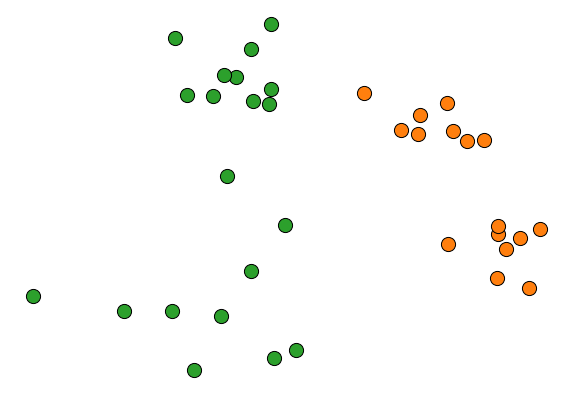

In [5]:
plt.figure(figsize = (10,7))
plt.axis("off")

for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, c1)
    
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, c2)
    
plt.show()

We compute the cost matrix $C_{ij} := \norm{x_i-y_j}^p$ for whatever $p$ we want, but we will use $p=2$ by default.

In [6]:
def distance_matrix(x, y, p=2):
    return np.linalg.norm(x[:,np.newaxis] - y, axis=-1)**p

C = distance_matrix(X,Y,2)

# Entropic Regularization of Optimal Transport

Lets solve the regularized transport problem, 

$$  L_C^\epsilon(a,b) = \umin{P \in U(a,b)} \dotp{C}{P}_F - \epsilon H(P).  $$

where the polytope of coupling is defined as

$$ U(a,b) = \enscond{P \in (\RR^+)^{n \times m}}{ P \mathbb{1}_m = a, P^\top \mathbb{1}_n = b },  $$

where $\mathbb{1}_n = (1,\ldots,1)^\top \in \RR^n $, and for $P \in \RR_+^{n \times m}$, we define its entropy as

$$ H(P) = -\sum_{ij} P_{ij} ( \log(P_{ij}) - 1). $$


The regularised transportation problem can be re-written as a projection of the Gibbs kernel $K$ in terms of the Kullback-Leibler divergence.

$$ L_C^\epsilon(a,b) = \epsilon \umin{P \in U(a,b)} \KLdiv{P}{K}
	\qwhereq
	K_{ij} = e^{ -\frac{C_{ij}}{\epsilon} }  $$
    

In this setting the Kullback-Leibler divergence between $P, K \in \RR_+^{n \times m}$ is

$$ 
\KLdiv{P}{K} = \sum_{ij} P_{ij} \pa{ \log\pa{ \frac{P_{ij}}{K_{ij}} } - 1} + K_{ij}.
$$


Given a convex set $\Cc \subset \RR^N$, the projection with respect to the Kullback-Leiber divergence is defined as

$$ \KLproj_\Cc(\xi) = \uargmin{ \pi \in \Cc } \KLdiv{\pi}{\xi}. $$

## Sinkhorn's Algorithm

A fundamental property of the optimal coupling $P^\epsilon$ is that it necessarily has the form 

$$
P^\epsilon = \diag{u} K \diag{v}
$$

where the $K$ is the Gibbs kernel defined earlier.

One thus needs to find two positive scaling vectors $u \in \RR_+^n$ and $v \in \RR_+^m$ such that the two following equality holds

$$
P \mathbb{1}_m  = u \odot (K v) = a 
\qandq
P^\top \mathbb{1}_n  = v \odot (K^\top u) = b.
$$

where $\odot$ denotes element-wise multiplication.

Sinkhorn's algorithm alternate between the resolution of these two equations, and reads

$$
u_{n+1} = \frac{a}{K v_n} \qandq v_{n+1} = \frac{b}{K^\top u_{n+1}}.
$$

where the division above is element-wise. This algorithm was shown to converge to a solution of the entropic regularised problem by Sinkhorn

According to **Remark 4.6** in Peyré and Cuturie, we can estimate the error of $P^\epsilon$ from a valid coupling $\hat P$ by evaluating

$$
\| a -  u_{n+1} \odot (Kv_{n+1}) \|_1 + \| b - v_n \odot (K^T u_{n+1}) \|_1
$$

The term $v_n$ is not a typo in the above equation. Because of the orders of updates, we would have $b = v_{n+1} \odot (K^T u_{n+1})$, which does not give us a helpful error estimate.

# Task 5: Implement the Sinkhorn method

Ideally, implement it in a function called ```sinkhorns_method(a, b, K, num_iter)```, so you can call it with different values of $\epsilon$, and to compare the elapsed time to compute between the different methods. Code ```sinkhorns_method``` to return the values of $u$ (```u```) and $v$ (```v```), as well as the error_vectors ```err_a``` and ```err_b```

__Important__: You should code your method to terminate Sinkhorn's method once the total error (as described above) goes below a certain amount, which here we take to be ```error_tol = 1e-4```. If the error tolerance hasn't been reached, then the method should terminate after ```max_iter``` iterations.

In [26]:
error_tol = 1e-4
max_iter = 20000

def sinkhorns_method(a, b, K, num_iter=max_iter):
    
    v = np.ones(m)

    err_a = np.zeros(num_iter)
    err_b = np.zeros(num_iter)
    
    # FILL IN THE CODE FOR THIS ROUTINE
    
    return u, v, err_a[:i], err_b[:i]



# Task 6: Calculate ```P``` from ```K```, ```u``` and ```v```

(it's not hard!)

We call the ```sinkhorns_method``` routine with the correct arguments, and use the values of ```u``` and ```v``` returned to calculate ```P```.

In [11]:
epsilon = 0.5

K = np.exp(-C/epsilon)

u, v, err_a, err_b =  sinkhorns_method(a, b, K)

#P = None # FILL IN THIS CODE HERE

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(np.log(np.asarray(err_a)), linewidth = 2, label='$|| \, P \mathbb{1}_m - a \,||$')
plt.plot(np.log(np.asarray(err_b)), linewidth = 2, label='$|| \, P^T \mathbb{1}_n - b \,||$')
plt.legend()
plt.show()

### Plot the coupling

We can plot the coupling graphically using lines with thickness proportional to the amount of mass transfer, and do a simple greyscale density plot as well.

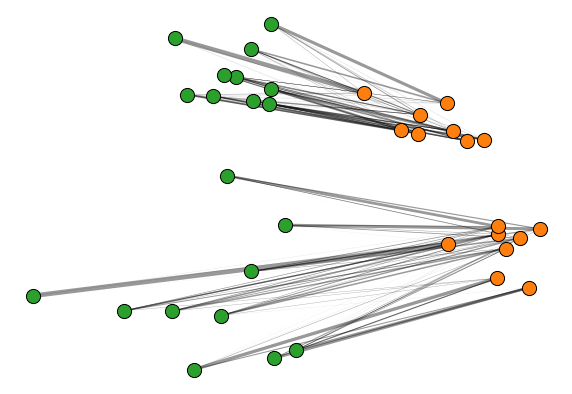

In [13]:
tol = 1e-8
I, J = np.nonzero(P > tol)

plt.figure(figsize = (10,7))
plt.axis('off')

for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, c1)
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, c2)
    
# Plot the lines between the points when there is a nonzero amount in the coupling between points
# Note that in this plot, the lines are proportional to the amount of mass coupled from a to b.
for k in range(len(I)):
    h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 100*P[I[k], J[k]], alpha=0.4, zorder=0)
plt.show()

# Lets test the entropic solutions against the LP solution

Use the code below to compare the transport plans computed through the LP method or through the Sinkhorn method.

In [30]:
def solve_OT_LP(a_loc, b_loc, C_loc):

    n_loc = len(a_loc)
    m_loc = len(b_loc)
    
    S = scipy.sparse.lil_matrix((n_loc, n_loc * m_loc), dtype=np.int8)
    T = scipy.sparse.lil_matrix((m_loc, n_loc * m_loc), dtype=np.int8)

    for i in range(n_loc):
        S[i, i*m_loc:(i+1)*m_loc] = 1

    for i in range(n_loc):
        T[:, i*m_loc:(i+1)*m_loc] = scipy.sparse.eye(m_loc, format='lil')

    A_eq = scipy.sparse.vstack([S, T])
    b_eq = np.hstack([a_loc, b_loc])
    c = C_loc.flatten()

    results = scipy.optimize.linprog(c, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=b_eq, options={'sparse':True})

    P = results.x.reshape((n_loc, m_loc))

    primal_min = results.fun
    return primal_min, P

def solve_OT_LP_dual(a_loc, b_loc, C_loc):
    
    n_loc = len(a_loc)
    m_loc = len(b_loc)
    
    S = scipy.sparse.lil_matrix((n_loc, n_loc * m_loc), dtype=np.int8)
    T = scipy.sparse.lil_matrix((m_loc, n_loc * m_loc), dtype=np.int8)

    for i in range(n_loc):
        S[i, i*m_loc:(i+1)*m_loc] = 1

    for i in range(n_loc):
        T[:, i*m_loc:(i+1)*m_loc] = scipy.sparse.eye(m_loc, format='lil')

    # Check dual problem
    c = -np.hstack([a, b])
    A_ub = scipy.sparse.vstack([S, T]).T
    b_ub = C.flatten()

    results = scipy.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None), options={'sparse':True})

    dual_min = -results.fun
    #P = results.x.reshape((n_loc, m_loc))
    f = results.x[:n_loc]
    g = results.x[n_loc:]

    return dual_min, f, g

### We also define a convenient function ```solve_OT_sinkhorns``` 

It computes the coupling and the minimum given the inputs of $a$, $b$, $C$ and $\epsilon$.

# Task 7: Complete the routine below

In particular - calculate $P$ in ```P_loc``` using the results from ```sinkhorns_method```, and then calculate the "Wasserstein distance" based on that coupling, that is, given ```P_loc```, calculate the total transport distance associated with it.

In [28]:
def solve_OT_sinkhorns(a_loc, b_loc, C_loc, epsilon=0.1):

    K_loc = np.exp(-C_loc/epsilon)
    
    u, v, err_a, err_b = sinkhorns_method(a_loc, b_loc, K_loc, 2000)
    
    P_loc = None # FILL IN THIS VALUE HERE
    
    W_eps = None # FILL IN THIS VALUE HERE
    
    return W_eps, P_loc

# Task 8: Compute the LP solutions using the routines provided, and compare with the regularised / Sinkhorn solutions, for various $\epsilon$

In [32]:
epsilons = [2., 1., 0.5, 0.2, 0.1]

W_primal, P = solve_OT_LP(a, b, C)
W_dual, f, g = solve_OT_LP_dual(a, b, C)

W_eps = np.zeros(len(epsilons))
P_eps = np.zeros((len(epsilons),) + P.shape)
for i, eps in enumerate(epsilons):
    W_eps[i], P_eps[i] = solve_OT_sinkhorns(a, b, C, epsilon=eps)

print(f'Primal LP, W(a,b) = {W_primal}\n')
print(f'Dual LP, W(a,b) = {W_dual}\n')
for eps, W in zip(epsilons, W_eps):
    print(f'Sinkhorn, epsilon = {eps}, W(a,b) ~ {W}')

Primal LP, W(a,b) = 9.132469877315991

Dual LP, W(a,b) = 9.132469373662929

Sinkhorn, epsilon = 2.0, W(a,b) ~ nan
Sinkhorn, epsilon = 1.0, W(a,b) ~ nan
Sinkhorn, epsilon = 0.5, W(a,b) ~ nan
Sinkhorn, epsilon = 0.2, W(a,b) ~ nan
Sinkhorn, epsilon = 0.1, W(a,b) ~ nan


### We plot the change in the coupling $P^\epsilon$ from $\epsilon = 2$ to $\epsilon = 0.1$

In the plot below, the blue edge corresponds edges $(i, j)$ given by $P^\epsilon_{ij}$ for which we also have $P_{ij} > 0$. The red edges are those for which $P^\epsilon_{ij} > 0$ but $P_{i,j} = 0$ (to within a tolerance, of course, which here is ```tol = 1e-8```.

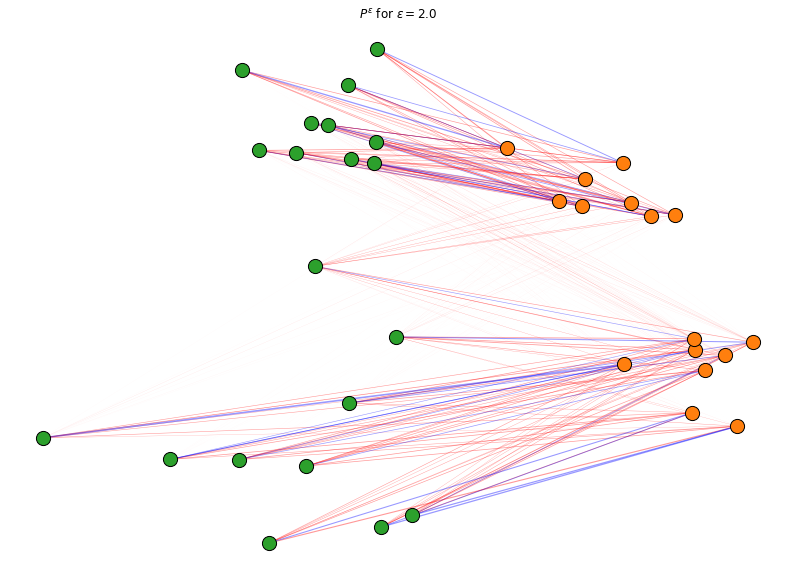

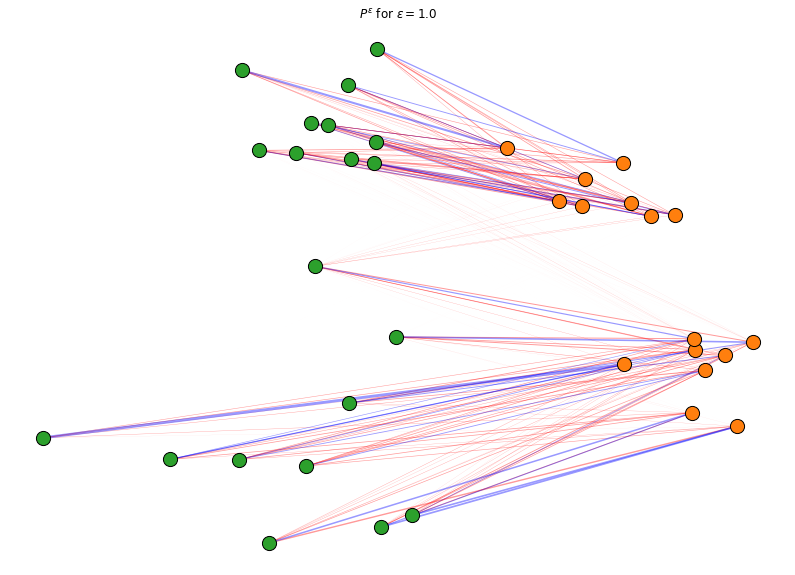

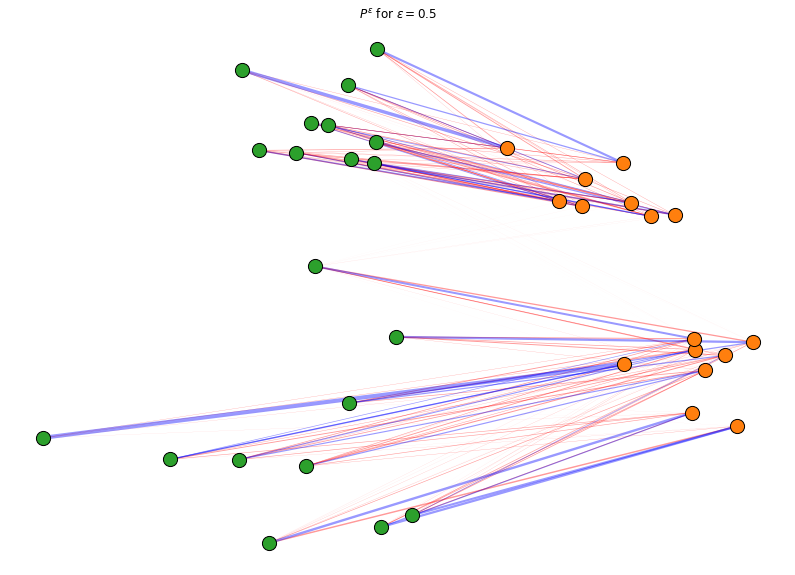

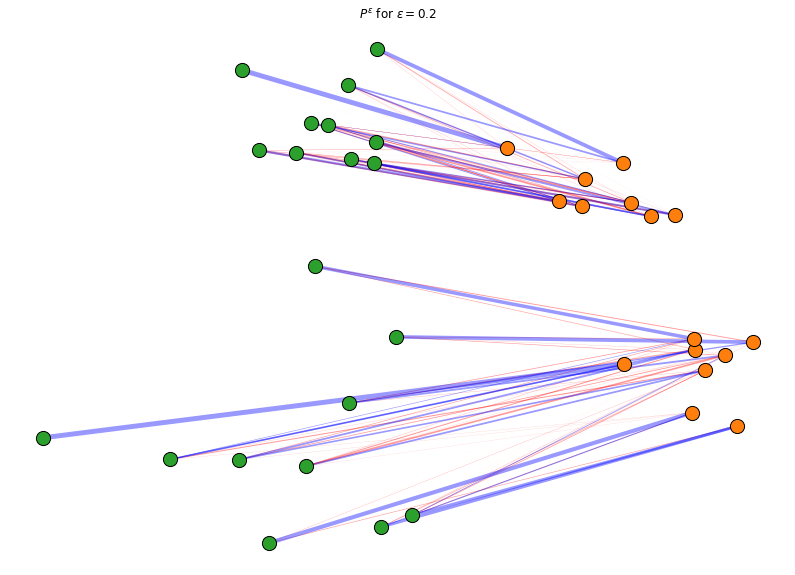

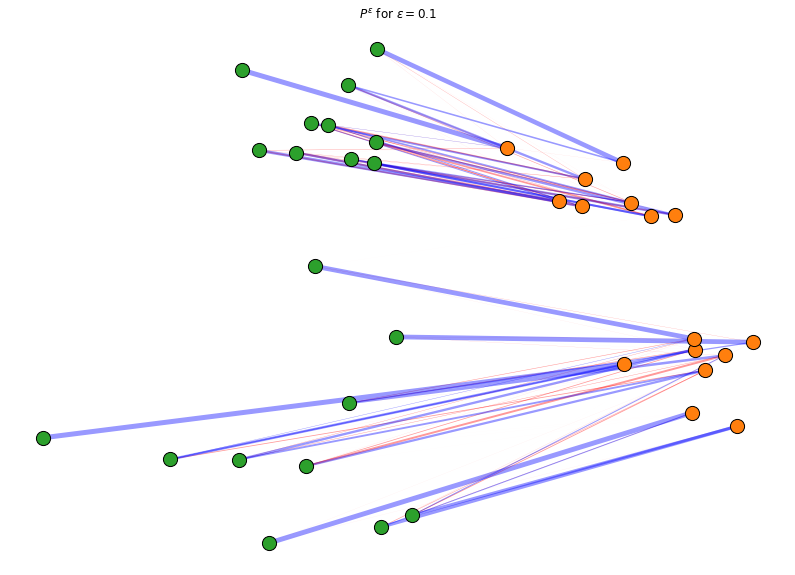

In [19]:
for l in range(len(epsilons)):
    
    plt.figure(figsize = (14,10))
    plt.axis('off')
    
    for i in range(len(a)):
        myplot(X[i,0], X[i,1], a[i]*len(a)*10, c1)
    for j in range(len(b)):
        myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, c2)

    P_eps_excess = P_eps[l] * (P < tol)
    P_eps_insuff = P_eps[l] * (P >= tol)
    
    I, J = np.nonzero(P_eps_excess > tol)
    for k in range(len(I)):
        h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'r', lw = 100*P_eps_excess[I[k], J[k]], alpha=0.4, zorder=0)
    
    I, J = np.nonzero(P_eps_insuff > tol)
    for k in range(len(I)):
        h = plt.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'b', lw = 100*P_eps_insuff[I[k], J[k]], alpha=0.4, zorder=0)
    plt.title(f'$P^\epsilon$ for $\epsilon = ${epsilons[l]}')
    plt.show()

# Task 9: Test the speed of the different approaches

So what's all the fuss about? The speed of Sinkhorn's method of course!

Lets test the speed of the different methods of solution. Test the speed of the regularised solution for all different values of $\epsilon$ that we used earlier, that is ```epsilons = [2.0, 1.0, 0.5, 0.2, 0.1]```.

You can use the ```time``` package or ```timeit```. Just calculate a simple wall time difference between the start of the operation and the end. To make it more accurate, we can repeat the calculation ```num_iter``` times, which will average out any hold-ups due to system use of the processor. 

In addition to this, generate a new _larger_ OT problem (where $n,m \sim 100$ or more, with random locations, and see how the problem scales. 

MAKE sure you print out the algorithm lapsed time!

In [ ]:
import time

num_repeats = 100

# FILL IN CODE HERE TO TIME THE DIFFERENT METHODS